<a href="https://colab.research.google.com/github/mirandasaari1/Predicting-Credit-Card-Default/blob/master/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Credit Card Default Using Various Classification Models and Ensemble Learning

Alexandria Davis, Miranda Saari, and Rosa Garza

# Introduction


In this report we will be exploring "The Default of Credit Card Clients" to try and predict the probability someone will default on their credit card. The dataset used for this report is from https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients. The set contains 30,000 instances with 23 attributes to show credit card default from April 2005 to September 2005, for our report we will be working with 25,000 instances. These attributes are: limit, sex, education, marriage, age, payment history by month, amount on bill statement, amount of previous payment, and amount paid. Some of the values within the attributes are not properly deescribed. We have found an email from the creator of the dataset which properly describes the values at https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset/discussion/34608. Gender is represented by 1 for male and 2 for female. Education is represented by 1 for graduate school, 2 for university, 3 for highschool and 4 for others. Marital status is represented by 1 for married, 2 for single, 3 for divorced, and 4 for others. Repayment status is represented by integer -2-9 to represent delay by month and is more explicitly described below. Bill statement and previous payment are represented by a variable for each month. 

### Libraries

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder,LabelBinarizer,StandardScaler, Imputer, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix,precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier

### Initial Data Load

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
input_file = "/content/gdrive/My Drive/CST463/project1/default_cc_train.csv"
dat = pd.read_csv(input_file)

# Exploration

Our dataset contains 25,000 observations of 25 raw features.

In [4]:
#dat.info
dat.shape

(25000, 25)

#### Individual Feature Exploration

Of these 25,000, a little over 5,000 of the observations in the data set defaulted. This makes up aproximately 20% of our overall data.

Text(0.5,1,'Credit Card Default Counts')

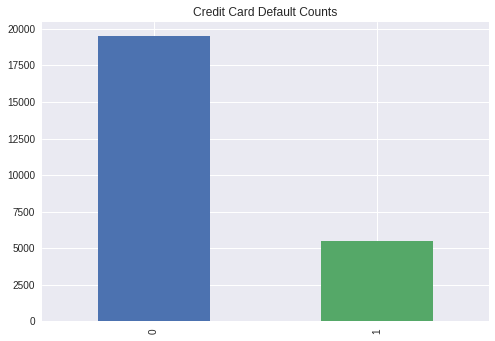

In [5]:
pd.value_counts(dat['default.payment.next.month']).plot.bar()
plt.title("Credit Card Default Counts")

The 5 most common credit card limits. Besides being in the ten thousands, there was not much of a patern. There were also no cards without limits, or that had an unlisted limit.

In [12]:
print(dat['LIMIT_BAL'].value_counts().nlargest(5))
print('\nNANs found:', sum(dat['LIMIT_BAL']==0) )

50000     2790
20000     1632
30000     1369
80000     1292
200000    1264
Name: LIMIT_BAL, dtype: int64
NANs found: 0


The dataset also had almost twice as many females listed as males, with none of the listed individuals having an unlisted sex.


In [13]:
print ("Gender: ")
print(dat['SEX'].value_counts()) 
print('NANs found: ', sum(dat['SEX']==0))

Gender: 
2    15109
1     9891
Name: SEX, dtype: int64


0

Most of the population has a university education and the majority has at least a high school education, however two of the values - 5 and 6 are not defined.
There are also 11 marked as "unknown" and 106 "others". The meaning behind these labels is not currently known.

In [8]:
print(dat['EDUCATION'].value_counts())
print('NANs found:', sum(dat['EDUCATION']==0) )

2    11682
1     8813
3     4115
5      236
4      106
6       37
0       11
Name: EDUCATION, dtype: int64


11

There is a pretty even dispersement of single and married in this data's population. We also have individuals who are divorced and very few that are under the category of "Others".

In [9]:
print(dat['MARRIAGE'].value_counts())
print('NANs found:', sum(dat['MARRIAGE']==0) )

2    13335
1    11352
3      267
0       46
Name: MARRIAGE, dtype: int64


46

The median age of our dataset is 34 years old, but the mode is for late twenties and early thirties. None of the entries of our dataset have unknown or unavalible values for this feature.

29    1327
27    1244
28    1174
30    1163
26    1045
31    1017
25     980
34     979
32     971
33     948
Name: AGE, dtype: int64
NANs found: 0


Text(0.5,1,'Age Distribution')

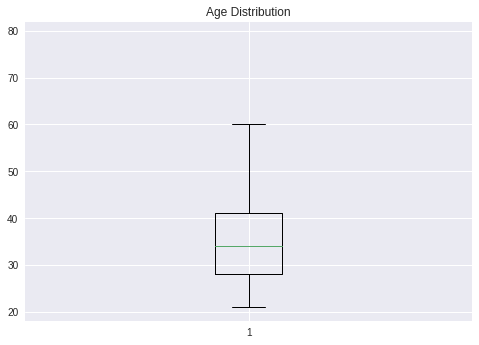

In [14]:
print(dat['AGE'].value_counts().nlargest(10))
print('NANs found:', sum(dat['AGE']==0)) 
plt.boxplot(dat['AGE']) 
plt.title("Age Distribution")

Looking at one of the six instances for previous payment amount we see the mode is 0. While it could be  case of having previous payment ammounts of zero, it may also be taking the place of a NAN. They may also be correlated to the six 'PAY' columns.

0       4379
2000    1155
3000     756
5000     599
1500     434
Name: PAY_AMT1, dtype: int64


Text(0.5,1,'ADD TITLE')

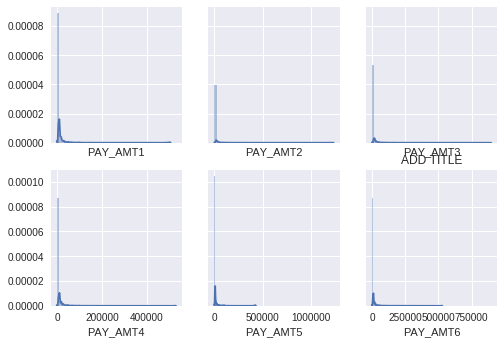

In [11]:
#things to consider, are the 0's here for the actual amount or representing nan
print(dat['PAY_AMT1'].value_counts().nlargest(5))
fig, ax = plt.subplots(2, 3, sharex='col', sharey='row')
sns.distplot(dat['PAY_AMT1'], ax=ax[0,0])
sns.distplot(dat['PAY_AMT2'], ax=ax[0,1])
sns.distplot(dat['PAY_AMT3'], ax=ax[0,2])
sns.distplot(dat['PAY_AMT4'], ax=ax[1,0])
sns.distplot(dat['PAY_AMT5'], ax=ax[1,1])
sns.distplot(dat['PAY_AMT6'], ax=ax[1,2])
plt.title("ADD TITLE")

 Looking at one of the six instances for previous payment amount we see the mode is 0, which means the minimum due amount was paid. -2 is included and the meaning is not described in the repo, but looking further we found 0 is minimum was paid, -1 balance was paid in full and -2 means no transactions occured that period. 

 0    12306
-1     4735
 1     3066
-2     2300
 2     2217
 3      262
 4       62
 5       23
 8       15
 7        7
 6        7
Name: PAY_0, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


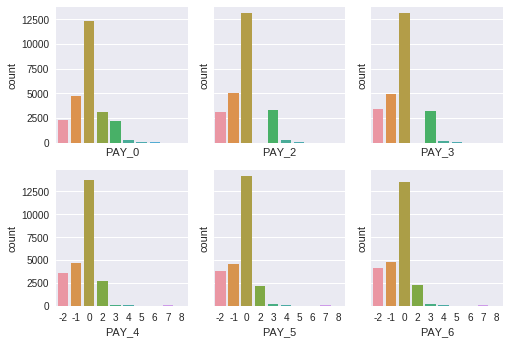

In [12]:
print(dat['PAY_0'].value_counts())
fig, ax = plt.subplots(2, 3, sharex='col', sharey='row')
sns.countplot(x="PAY_0", data=dat, ax=ax[0,0])
sns.countplot(x="PAY_2", data=dat, ax=ax[0,1])
sns.countplot(x="PAY_3", data=dat, ax=ax[0,2])
sns.countplot(x="PAY_4", data=dat, ax=ax[1,0])
sns.countplot(x="PAY_5", data=dat, ax=ax[1,1])
sns.countplot(x="PAY_6", data=dat, ax=ax[1,2])

We found the 'Bill_AMT' variables contatin negative values in the case a customer overpays their bill. This could be caused by an automatic payment set if the bill for that month is not as high as the automatic payment is set for.

0      1671
390     199
780      65
326      64
316      56
Name: BILL_AMT1, dtype: int64


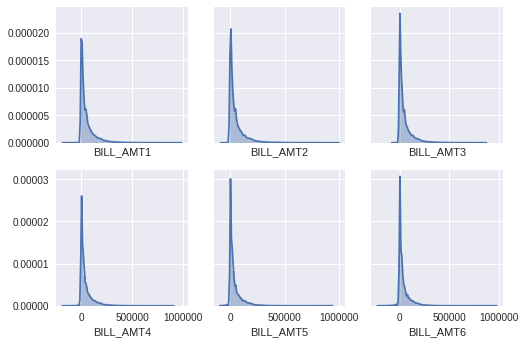

In [13]:
#things to consider, are the 0's here for the actual amount or representing nan
print(dat['BILL_AMT1'].value_counts().nlargest(5))
fig, ax = plt.subplots(2, 3, sharex='col', sharey='row')
sns.distplot(dat['BILL_AMT1'], ax=ax[0,0])
sns.distplot(dat['BILL_AMT2'], ax=ax[0,1])
sns.distplot(dat['BILL_AMT3'], ax=ax[0,2])
sns.distplot(dat['BILL_AMT4'], ax=ax[1,0])
sns.distplot(dat['BILL_AMT5'], ax=ax[1,1])
sns.distplot(dat['BILL_AMT6'], ax=ax[1,2])

### Feature Correlation Exploration

As far as education goes there seems to be pretty equal likeliness for each class. Male's tend to have a high default rate for each which is interesting considering this set contains almost double the amount of females.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


Text(0.5,1,'Default by Education and Sex')

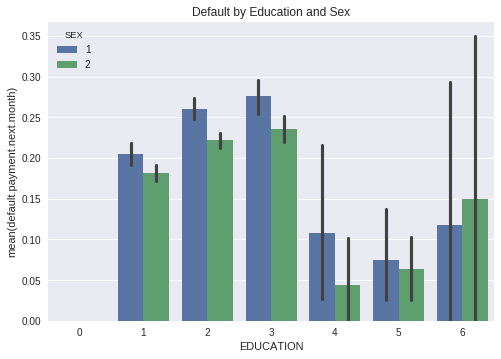

In [14]:
dat['default.payment.next.month'].value_counts()
sns.barplot(x="EDUCATION", y="default.payment.next.month", hue="SEX", data=dat)
plt.title("Default by Education and Sex")

When checking if the age at which individuals default was correlated by gender, it can be observed that the age at which the sexes default is relatively similar.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


Text(0.5,1,'Distribution of Default by Age')

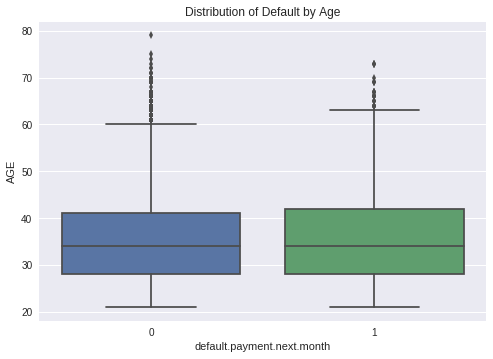

In [15]:
sns.boxplot(x="default.payment.next.month", y="AGE", data=dat)
plt.title("Distribution of Default by Age")

Below are violin plots where we visualize the distribution of ages based on an individual's sex and whether or not they default the next month. It was interesting to see that the two samples of those who default and those who didn't seemed to have similar distribution shapes, so by just looking only at a person's sex and age may not be the best to see if whether a person will default or not.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:637: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data[hue_mask])
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:885: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data[hue_mask])
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:905: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


Text(0.5,1,'Distribution of Default by Sex and Age')

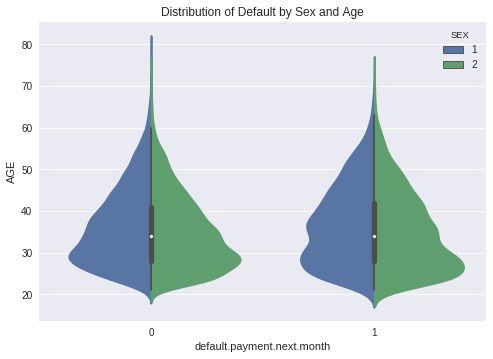

In [16]:
sns.violinplot(x="default.payment.next.month", y="AGE", hue="SEX", data=dat, split=True)
plt.title("Distribution of Default by Sex and Age")

# Preprocessing

### Feature Manipulation


Since the Education column contained two unnamed values: 5 and 6, we decided to make both values 5 and delegate 5 as unknown.

In [17]:
dat['EDUCATION'].loc[dat['EDUCATION'] == 6]=5
dat['default.payment.next.month'].value_counts()

0    19486
1     5514
Name: default.payment.next.month, dtype: int64

### Derived Features

As part of our preprocessing, we decided to derive more features. We first summed the bill amount of each person between April 2005 -August 2005 since we were provided corresponding information on the payments for these specific months.

In [0]:
total_balance=dat[['BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']]
dat['total_balance']=total_balance.sum(axis=1)

In [0]:
total_pay_amount=dat[['PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4','PAY_AMT5']]
dat['total_pay_amount']=total_pay_amount.sum(axis=1)

Not only are the total balances and total amounts important, but we also decided that looking at the difference between the two amounts might be valuable. We subtracted the total_pay_amount from total_balance in which we decided to see how much was left of the person's credit card balance between a specific time period.

In [0]:
dat['total_diff']=dat['total_balance']-dat['total_pay_amount']

Another derived feature was summing the total pay information for each individual in which we could get an overall view of whether a person does not use their credit card too often or is consistently late on payments.

In [0]:
pay_len=dat[['PAY_0', 'PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']]
dat['pay_over_time']=pay_len.sum(axis=1)

Because the values inputted in the PAY columns are negative and positive, the  sum of these values do not show enough information of the person's credit card payment patterns. We decided to create four other features to reflect how many times they didn't use their credit card, paid their bill in full, used their revolving credit, and how many total months they were late on payments.

In [0]:
dat['total_no_cons']=(pay_len ==-2 ).sum(axis=1)
dat['total_full_pay']=(pay_len ==-1 ).sum(axis=1)
dat['revolve_credit']=(pay_len ==0 ).sum(axis=1)
dat['late_pays']=(pay_len >0 ).sum(axis=1)

### Data Separation

Several other features also represented factors better than they represented numeric values. For example, gender, marriage, and education also do not follow the standard numerical rulesare better as categories. The individual Pay columns also benefit from being factors. 

In [0]:
as_category = ['PAY_0', 'PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','SEX','EDUCATION','MARRIAGE']

Array of numeric data labels

In [0]:
as_numeric = ['ID','LIMIT_BAL','AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
             'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4','PAY_AMT5', 'PAY_AMT6','total_balance','total_pay_amount','total_diff',
             'pay_over_time','total_no_cons','total_full_pay','revolve_credit','late_pays']

Vector of output labels

In [25]:
labels = ['default.payment.next.month']

0    19486
1     5514
Name: default.payment.next.month, dtype: int64

### Preprocessing Definitions

In [0]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
         return X[self.attribute_names]

In [0]:
class DummyEncoder(TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def transform(self, X, y=None, **kwargs):
        return pd.get_dummies(X, columns=self.columns)
    def fit(self, X, y=None, **kwargs):
        return self

### Pipelines

In [0]:
num_pipe=Pipeline([
        ("selector", DataFrameSelector(as_numeric)),
        ("scale", StandardScaler())
        ])

In [0]:
cat_pipe=Pipeline([
        ("selector", DataFrameSelector(as_category)),
        ("convert", DummyEncoder(columns=as_category)),
        ("scale", StandardScaler())
        ])


In [0]:
full_pipeline = FeatureUnion(transformer_list=[
        ("cat_pipeline", cat_pipe ),
        ("num_pipeline", num_pipe ),
        ])

In [0]:
dat_prepared = full_pipeline.fit_transform(dat)

# Create Train and Test Sets


We reserved 30% of the data for the test set, the remainder acting as the training set.

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(dat_prepared,dat[labels], test_size=0.3)

# Dimensionality Reduction


### PCA

We first used PCA to find the optimum number of dimensions, with 25 dimensions, the original number of dimensions before derived and dummie features were added, we see about 12% of the datas variance lies along the first axis.

In [33]:
pca = PCA(n_components = 25)
X25D = pca.fit_transform(X_train)
print(pca.explained_variance_ratio_)

[0.11892624 0.06415455 0.0585116  0.05344484 0.04956592 0.03830502
 0.0325336  0.03099279 0.02597735 0.02512528 0.0230947  0.01953612
 0.01890009 0.01718859 0.01664267 0.0157442  0.01505816 0.01420303
 0.01363419 0.01335899 0.01225485 0.01171167 0.01158411 0.01126945
 0.01108065]


We then ran a form of PCA which would find the number of copmonents which would be required to get 95%. After running this we saw 50 was the minimum number of components needed to preserve 95% of the training set's variance. We plotted the cumsum and found the elbow to appear around 50. Since 50 principle components is not ideal we decided to explore other dimensionality reduction techniques. 

55
[0.11892624 0.06415455 0.0585116  0.05344484 0.04956594 0.03830506
 0.03253365 0.03099288 0.02598036 0.02512566 0.02309576 0.01954144
 0.01890692 0.01721266 0.01664956 0.01575583 0.0151034  0.01424129
 0.01368353 0.01342601 0.01242338 0.01185722 0.01167156 0.01143843
 0.01124114 0.01075825 0.0103949  0.01027845 0.01005896 0.00991603
 0.00983989 0.00971677 0.00962521 0.00942225 0.0091054  0.0087589
 0.00870542 0.00829374 0.00800468 0.00787532 0.00780333 0.00745614
 0.0073001  0.0071215  0.00692791 0.00643433 0.0060308  0.00589598
 0.00579516 0.0054019  0.00495368 0.00488179 0.00479819 0.00421225
 0.00400382]


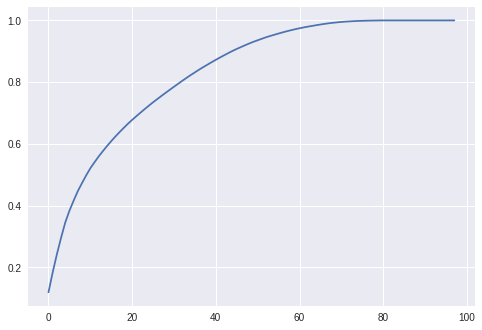

In [34]:
pca2 = PCA()
pca2.fit(X_train)
cumsum = np.cumsum(pca2.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print(d)
pca2 = PCA(n_components = d)
XdD = pca2.fit_transform(X_train)
print(pca2.explained_variance_ratio_)
plt.plot(cumsum)

### LLE

Since PCA did not work well with our dataset, we moved onto locally linear embedding to try and reduce our dimensions. Using LLE we reduced our dimensions to 2. We later tested the reduced dimensions with LLE.

In [0]:
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced = lle.fit_transform(X_train)

# Models

### Logistic Regression

For our first classifier model, we developed a Logistic Regression model. We printed out the score of the model on the trained data set versus the test data set. Based on the two scores we can see that there is no issue of an overfit, and that the model has over an 80% accuracy.

In [36]:
clf_reg=LogisticRegression()
clf_reg.fit(X_train,Y_train)
Y_pred_logr=clf_reg.predict(X_train)
Y_predict_logr=clf_reg.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [79]:
print("Score of Logistic Regression Model on train: ","{0:.4f}".format(clf_reg.score(X_train,Y_train)))

Score of Logistic Regression Model on train:  0.8220
Score of Logistic Regression Model on test:  0.8165333333333333


### Logistic Regression with LLE

By using the training test produced from LLE we actually saw about a 4% decrease in accuracy. Although it was unfortunate not to see our accuracy improve, the model would be adequate for a situation where the results need to be explained.

In [38]:
clf_reg_lle=LogisticRegression()
clf_reg_lle.fit(X_reduced,Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [39]:
print("Score of Logistic Regression Model with LLE on train: ","{0:.4f}".format(clf_reg_lle.score(X_reduced,Y_train)))

Score of Logistic Regression Model with LLE on train:  0.7790


### SVC

We then developed a Support Vector Machine model, specifically a Soft Margin Classifier (SVC). For this model, we also looked at the score on the train and test set in order to see the model's overall performance. We do see a difference in perfomance if we compared this model to a simple logistic regression model. Our score for the Soft Margin Classifier is in fact very similar to the Logistic Regression model.

In [40]:
svm_clf=LinearSVC()
svm_clf.fit(X_train,Y_train)
Y_train_pred_svm=svm_clf.predict(X_train)
Y_predict_clf=svm_clf.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [41]:
print("Score of SVM Regression Model on train: ",svm_clf.score(X_train,Y_train))

Score of SVM Regression Model on train:  0.8208


### SVC with LLE

Similar to Logistic Regression, the accuracy did not improve with the set from dimensionality reduction.

In [42]:
svm_clf_lle=LinearSVC()
svm_clf_lle.fit(X_reduced,Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [43]:
print("Score of SVM Regression Model with LLE on train: ","{0:.4f}".format(svm_clf_lle.score(X_reduced,Y_train)))

Score of SVM Regression Model with LLE on train:  0.7820


# Fine Tuning

Since the Logistic Regression model slightly performed better than a SVM Classifier, we decied to fine tune the Logistic Regression model. GridSearchCV was implemented in order to find the best hyperparameters.

In [44]:
logreg_grid=[
    {'C':[0.001, 0.01, 0.1, 1, 1.01,1.1],
     'max_iter':[100,1000],'warm_start':['True','False']},
]
log_reg=LogisticRegression()
grid_search=GridSearchCV(log_reg,logreg_grid,cv=5,scoring='neg_mean_squared_error')
grid_search.fit(X_train,Y_train.values.ravel())

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.001, 0.01, 0.1, 1, 1.01, 1.1], 'max_iter': [100, 1000], 'warm_start': ['True', 'False']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

We then stored a copy the best hyperparameter values in order to tune our model and begin training again.

In [45]:
print("Best Parameters:",grid_search.best_params_)

Best Parameters: {'C': 0.1, 'max_iter': 100, 'warm_start': 'True'}


In [0]:
best_c_param=grid_search.best_params_.get('C')
best_max_iter_param=grid_search.best_params_.get('max_iter')
best_warm_start_param=grid_search.best_params_.get('warm_start')

# Re-Tuned Model

We now begin to retrain our re-tuned Logistic Regression model in comparison with a Logistic Regression model with LLE dimensionality reduction.

### Logistic Regression

In [47]:
clf_reg_retuned=LogisticRegression(C=best_c_param,max_iter=best_max_iter_param,
                                  warm_start=best_warm_start_param)
clf_reg_retuned.fit(X_train,Y_train)
Y_pred_logr_retuned=clf_reg_retuned.predict(X_train)
Y_predict_logr_retuned=clf_reg_retuned.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [48]:
print("Score of Logistic Regression Model on train: ","{0:.4f}".format(clf_reg_retuned.score(X_train,Y_train)))

Score of Logistic Regression Model on train:  0.8221


### Logistic Regression using LLE

In [49]:
clf_reg_lle_retuned=LogisticRegression(C=best_c_param,max_iter=best_max_iter_param,
                                  warm_start=best_warm_start_param)
clf_reg_lle_retuned.fit(X_reduced,Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start='True')

In [50]:
print("Score of Logistic Regression Model with LLE on train: ","{0:.4f}".format(clf_reg_lle_retuned.score(X_reduced,Y_train)))

Score of Logistic Regression Model with LLE on train:  0.7790


Based on the scores of the Logistic Regression model and the Logistic Regression model with LLE dimensionality reduction after being re-tuned, we noticed the model performed slightly better without the use of LLE, so we have decided to try an ensemble method.

# Ensemble Learning

## Bagging Classifier

Because our previous models were not improving as much as we would have liked, we then turned to ensemble learning. For our first method, we tried a Bagging Classsifier using a Decision Tree Classifier.

Many of the parameters were manually adjusted while looking at the score on the training and test set.

In [0]:
bag_clf=BaggingClassifier(
    DecisionTreeClassifier(splitter='random',max_depth=10,max_features=47),n_estimators=500,
    max_samples=320,bootstrap=True,n_jobs=-1,oob_score=False)
bag_clf.fit(X_train,Y_train.values.ravel())
predict_bagging=bag_clf.predict(X_test)

Below we can see the two scores on the training and test set in which this method showed slight improvements from our previous models. Not only that, but we can see that we are not overfitting since our score on the test set did not have a significantly large difference compared to the training set.

In [53]:
print("Decision Tree Classifier with Bagging Score on Training: ", "{0:.4f}".format(bag_clf.score(X_train,Y_train)))

Decision Tree Classifier with Bagging Score on Training:  0.8226


In [54]:
print("Decision Tree Classifier with Bagging Score on Test :","{0:.4f}".format(bag_clf.score(X_test,Y_test)))

Decision Tree Classifier with Bagging Score on Test : 0.8169


## Voting Classifier

We then implemented a Voting Classifier using 3 of our previous models: Logistic Regression, LinearSVC, and DecisionTreeClassifier. A new model added was a Random ForestClassifier.

In [71]:
log_clf=LogisticRegression(C=best_c_param,max_iter=best_max_iter_param,
                                  warm_start=best_warm_start_param)
rnd_clf=RandomForestClassifier(bootstrap=True,max_depth=5,max_features=30,
                               n_estimators=155)
svm_clf=LinearSVC(C= 0.01, loss= 'squared_hinge')
dt_clf=DecisionTreeClassifier(splitter='random',max_depth=10,max_features=47)
voting_clf=VotingClassifier(
    estimators=[('lr',log_clf),
               ('rf',rnd_clf), ('svc',svm_clf),('dt',dt_clf)],voting='hard')
voting_clf.fit(X_train, Y_train.values.ravel())
predict_voting=voting_clf.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


To see our overall performance from the Voting Classifier, we printed out the accuracy score of each model used within the classifier as well as the overall accuracy score of the model.

In [72]:
for class_algo in (log_clf, rnd_clf,svm_clf,dt_clf,voting_clf):
    class_algo.fit(X_train,Y_train.values.ravel())
    y_pred=class_algo.predict(X_test)
    print(class_algo.__class__.__name__,
         accuracy_score(Y_test,y_pred))

LogisticRegression 0.8166666666666667
RandomForestClassifier 0.8170666666666667
LinearSVC 0.8166666666666667
DecisionTreeClassifier 0.8116
VotingClassifier 0.8176


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Evaluation

To evaluate three of our top models, we will focus on the confusion matrices, classification model, and accuracy scores in order to see  the models' performances with classification.

## Logistic Regression

### Confusion Matrix

Below is the confusion matrix for the logistic regression model.  In counter clockwise order, we have true negatives, false negatives, true positives, and then false positives. We notice that for our Logistic Regression model we had many true negatives which means we had many correct guesses for a person not defaulting on their credit card. 

In [59]:
confusion_matrix(Y_test,Y_predict_logr)

array([[5566,  288],
       [1088,  558]])

### Classification Report

A classification report was then ran in which we now see the precision and recall values.

In [60]:
print(classification_report(Y_test,Y_predict_logr))

             precision    recall  f1-score   support

          0       0.84      0.95      0.89      5854
          1       0.66      0.34      0.45      1646

avg / total       0.80      0.82      0.79      7500



### ROC

Looking at the plot for Logistic Regression's true positive rate versus false positive rate we see our classifier is mediocre. We did not see as much of a curve in the line representing the sensitivity as we would have preferred.

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


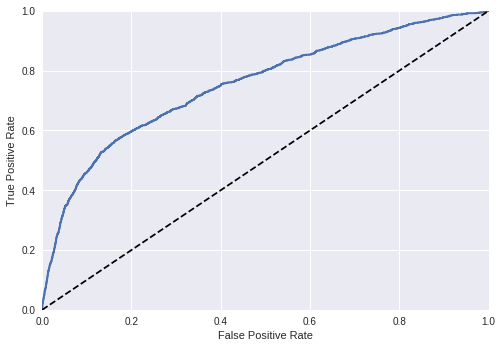

In [65]:
y_scores_reg = cross_val_predict(clf_reg, X_test, Y_test, cv=3,method="decision_function")
fpr, tpr, thresholds = roc_curve(Y_test, y_scores_reg)
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.axis([0, 1, 0, 1])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()

From the ROC's Area Under the Curve score we see the performance is almost half way between the classifier being "perfect" and completely random.

In [66]:
roc_auc_score(Y_test, y_scores_reg)

0.7548521724041594

## Bagging Classifier

### Confusion Matrix

Below is the confusion matrix for the Bagging Classifier.

In [61]:
confusion_matrix(Y_test,predict_bagging)

array([[5539,  315],
       [1058,  588]])

### Classification Report

In order to see the performance, we looked further at the classification report.

In [62]:
print(classification_report(Y_test,predict_bagging))

             precision    recall  f1-score   support

          0       0.84      0.95      0.89      5854
          1       0.65      0.36      0.46      1646

avg / total       0.80      0.82      0.80      7500



### ROC

The ROC of the bagging classier showed a sharp curve, but this curve was even closer to the line representing a completely random classifier than Logistic Regression.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


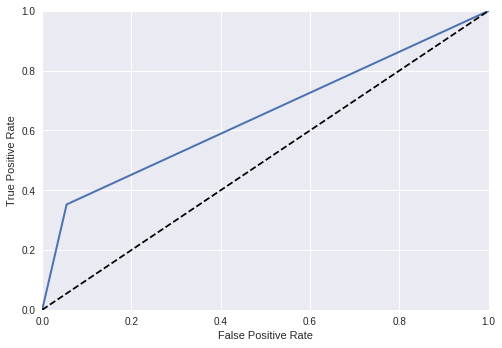

In [74]:
y_scores_bag = cross_val_predict(bag_clf, X_test, Y_test, cv=3)
fpr, tpr, thresholds = roc_curve(Y_test, y_scores_bag)
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.axis([0, 1, 0, 1])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()

Which is understandable when seeing the ROC AUC of bagging was a lot closer to the "random" performance standard.

In [75]:
roc_auc_score(Y_test, y_scores_bag)

0.6488529511760659

## Voting Classifier

Below is the confusion matrix for the Voting Classifier.

### Confusion Matrix

In [63]:
confusion_matrix(Y_test,predict_voting)

array([[5578,  276],
       [1094,  552]])

In order to see the performance, we looked further at the classification report.

### Classification Report

In [64]:
print(classification_report(Y_test,predict_voting))

             precision    recall  f1-score   support

          0       0.84      0.95      0.89      5854
          1       0.67      0.34      0.45      1646

avg / total       0.80      0.82      0.79      7500



### ROC

Lastly the ROC plot for the voting classifier was almost the same as the plot for the bagging classifier. The curve did appear a little lower in the following plot.

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, 

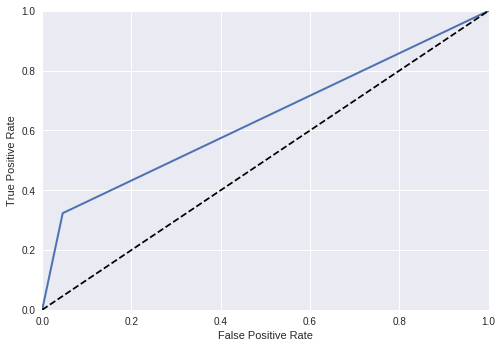

In [77]:
y_scores_voting = cross_val_predict(voting_clf, X_test, Y_test, cv=3)
fpr, tpr, thresholds = roc_curve(Y_test, y_scores_voting)
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.axis([0, 1, 0, 1])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()

Once again, the Voting Classifier's ROC AUC score is only a little lower than the Bagging Classifier's. Showing the classifier performs closer to the "random" side.

In [78]:
roc_auc_score(Y_test, y_scores_voting)

0.6386281451321981

## Model Accuracies

From all of our training on different learning algorithms, below we can compare the accuracy scores from all of our used models in order to see how well we are able to determine whether a person defaults on their credit card or not.

In [69]:
print("Accuracy of Logistic Regression Model: ",
      float("{0:.4f}".format(accuracy_score(Y_test,Y_predict_logr))))
print("Accuracy of SVC Model: ",
      float("{0:.4f}".format(accuracy_score(Y_test,Y_predict_clf))))
print("Accuracy of Bagging Classifier: ",
      float("{0:.4f}".format(accuracy_score(Y_test,predict_bagging))))
print("Accuracy of Voting Classifier: ",
      float("{0:.4f}".format(accuracy_score(Y_test,predict_voting))))

Accuracy of Logistic Regression Model:  0.8165
Accuracy of SVC Model:  0.8155
Accuracy of Bagging Classifier:  0.8169
Accuracy of Voting Classifier:  0.8173


# Conclusion

  After exploring, manipulating and experimenting with different models on the credit card default data set we have obtained a maximum accuracy of 0.82 or 82% to determine whether a person defaults on their credit card or not. Ideally we would have been able to increase this accuracy by trying out various ways of preprocessing the data, utilizing dimensionality reduction, fine-tuning the models' hyperparameters, and applying ensemble learning. 
  
   First we derived new features from the data set. Since this resulted in about 100 features we explored dimensionality reduction. Using the second form of reduction, LLE, we ran our initial classification models, Logistic Regression and Support Vector Classifier with original training set and the reduced set. Seeing no improvement with the set produced in LLE we continued using our original training set.
   
  Next we fine-tuned the better performing model, Logisitic Regression, with GridSearchCV as another attempt to improve the model. After using GridSearchCV no significant improvements were seen. 
  
  This led us to trying ensemble learning to see if our overall accuracy could be improved by combining various models' predictions. Once again there did not seem to be a significant improvement in both the Bagging Classifier and Voting Classifier  when compared to our Logisitic Regression model.
  
  In the end, looking at the accuracy scores of each model was not enough information to choose which model performed best when trying to predict whether or not a person would default on their credit card. Above one can clearly see how close all these accuracy scores fall. In fact, by just seeing the accuracy scores the Voting Classifier seems to perform the best. But if looks at performance via ROC curves the Logistic Regression model seems to perform the best and the Voting Classifier does significantly worse.
  
  For future work, we think it would be interesting to develop more complex models, such as implementing a neural network and seeing if there could be a better performance of an 82% accuracy score since all our previous techniques did not seem to effect the accuracy.
  